In [1]:
import numpy as np
import pandas as pd
import ipdb
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, asin, sqrt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [2]:

# Load the training dataset
train_df = pd.read_csv(r'C:\Users\o.gezerli\OneDrive - FlixBus GmbH (B2E B2B) - Prod\Desktop\code_projects\nyc_taxi_trip_duration_python\nyc_taxi_trip_duration\data\train.csv',on_bad_lines='skip')
# Print the first 5 rows of the dataset
train_df.head()


C:\Users\o.gezerli\AppData\Local\Temp\ipykernel_20496\2661988154.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(r'C:\Users\o.gezerli\OneDrive - FlixBus GmbH (B2E B2B) - Prod\Desktop\code_projects\nyc_taxi_trip_duration_python\nyc_taxi_trip_duration\data\train.csv',on_bad_lines='skip')


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.78252,N,435.0


In [3]:
test_df = pd.read_csv(r'C:\Users\o.gezerli\OneDrive - FlixBus GmbH (B2E B2B) - Prod\Desktop\code_projects\nyc_taxi_trip_duration_python\nyc_taxi_trip_duration\data\test.csv')


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930061 entries, 0 to 930060
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  930061 non-null  object 
 1   vendor_id           930061 non-null  int64  
 2   pickup_datetime     930061 non-null  object 
 3   dropoff_datetime    930061 non-null  object 
 4   passenger_count     930061 non-null  int64  
 5   pickup_longitude    930061 non-null  float64
 6   pickup_latitude     930061 non-null  float64
 7   dropoff_longitude   930061 non-null  float64
 8   dropoff_latitude    930061 non-null  object 
 9   store_and_fwd_flag  930060 non-null  object 
 10  trip_duration       930060 non-null  float64
dtypes: float64(4), int64(2), object(5)
memory usage: 78.1+ MB


In [5]:
train_df.describe()


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,trip_duration
count,930061.000000,930061.000000,930061.000000,930061.000000,930061.000000,930060.000000
mean,1.508762,1.605882,-73.975191,40.743919,-73.976606,905.496964
std,0.499923,1.263716,0.046321,0.035696,0.027408,1640.152951
min,1.000000,0.000000,-77.896019,37.777771,-77.896019,1.000000
25%,1.000000,1.000000,-73.998734,40.724667,-73.991180,413.000000
50%,2.000000,1.000000,-73.986832,40.745327,-73.978989,802.000000
75%,2.000000,2.000000,-73.969620,40.769341,-73.965775,1156.000000
max,2.000000,6.000000,-72.809669,51.881084,-72.711395,86390.000000


In [6]:
train_df = train_df.dropna()

<Axes: ylabel='trip_duration'>

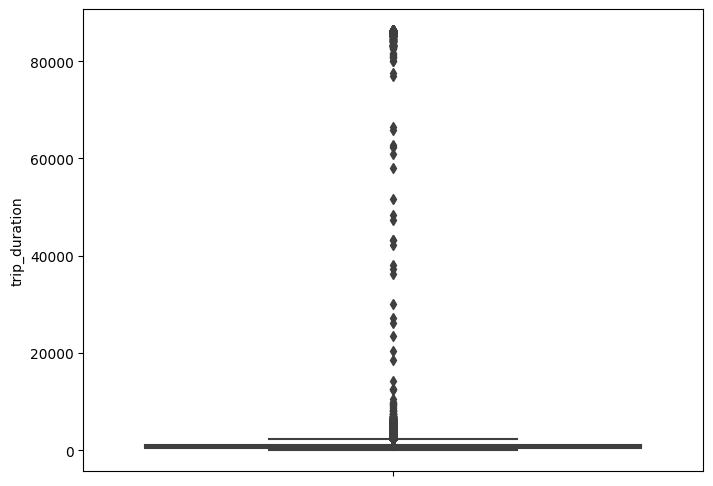

In [7]:
plt.figure(figsize=(8,6))
sns.boxplot(y=train_df['trip_duration'])

(array([119818., 273147., 134139., 199543.,  78314.,  58974.,  18391.,
         27854.,   2445.,   1652.]),
 array([1.0000e+00, 3.0080e+02, 6.0060e+02, 9.0040e+02, 1.2002e+03,
        1.5000e+03, 1.7998e+03, 2.0996e+03, 2.3994e+03, 2.6992e+03,
        2.9990e+03]),
 <BarContainer object of 10 artists>)

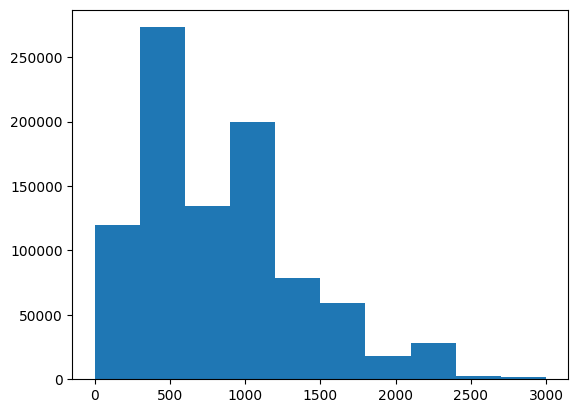

In [8]:
plt.hist(train_df[train_df['trip_duration'] < 3000]['trip_duration'])

In [9]:
train_df.trip_duration.quantile(0.25)

413.0

In [10]:
train_df.trip_duration.quantile(0.75)

1156.0

In [11]:
# Define the upper and lower percentiles for outlier detection (e.g., 1st and 99th percentiles)
lower_percentile = train_df['trip_duration'].quantile(0.01)
upper_percentile = train_df['trip_duration'].quantile(0.99)

# Identify outliers
outliers = (train_df['trip_duration'] < lower_percentile) | (train_df['trip_duration'] > upper_percentile)

# Remove outliers from the dataset
train_df = train_df[~outliers]

# Optionally, reset the index of the DataFrame
train_df.reset_index(drop=True, inplace=True)


<Axes: ylabel='trip_duration'>

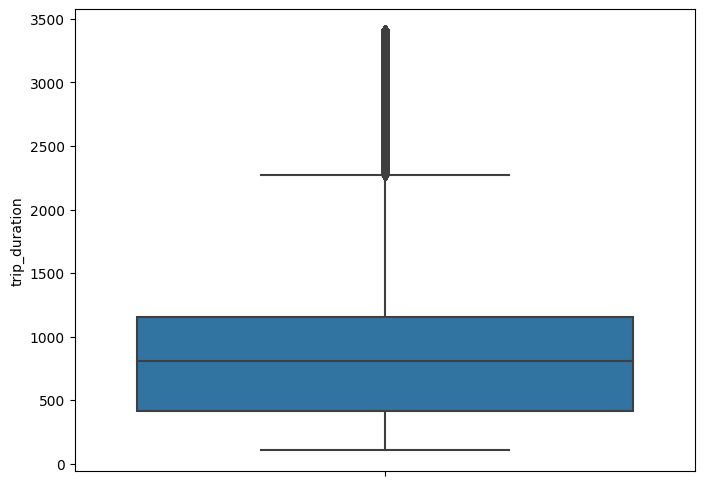

In [12]:
plt.figure(figsize=(8,6))
sns.boxplot(y=train_df['trip_duration'])

In [13]:
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])
train_df['dropoff_datetime'] = pd.to_datetime(train_df['dropoff_datetime'])
train_df['hour'] = train_df['pickup_datetime'].dt.hour
train_df['dayofweek'] = train_df['pickup_datetime'].dt.dayofweek
train_df['month'] = train_df['pickup_datetime'].dt.month

In [14]:
train_df = train_df.drop(['pickup_datetime', 'dropoff_datetime'], axis = 1)

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924334 entries, 0 to 924333
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  924334 non-null  object 
 1   vendor_id           924334 non-null  int64  
 2   passenger_count     924334 non-null  int64  
 3   pickup_longitude    924334 non-null  float64
 4   pickup_latitude     924334 non-null  float64
 5   dropoff_longitude   924334 non-null  float64
 6   dropoff_latitude    924334 non-null  object 
 7   store_and_fwd_flag  924334 non-null  object 
 8   trip_duration       924334 non-null  float64
 9   hour                924334 non-null  int32  
 10  dayofweek           924334 non-null  int32  
 11  month               924334 non-null  int32  
dtypes: float64(4), int32(3), int64(2), object(3)
memory usage: 74.0+ MB


In [16]:
train_df['dropoff_latitude'] = train_df['dropoff_latitude'].astype('float64')
train_df['store_and_fwd_flag'] = train_df['store_and_fwd_flag'] == 'Y'

In [17]:
train_df['store_and_fwd_flag'] .unique()

array([False,  True])

In [18]:
train_df['vendor_id'] = train_df['vendor_id'].astype('category')

In [19]:
train_df.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour,dayofweek,month
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,False,455.0,17,0,3
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,False,663.0,0,6,6
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,False,2124.0,11,1,1
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,False,429.0,19,2,4
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,False,435.0,13,5,3


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924334 entries, 0 to 924333
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   id                  924334 non-null  object  
 1   vendor_id           924334 non-null  category
 2   passenger_count     924334 non-null  int64   
 3   pickup_longitude    924334 non-null  float64 
 4   pickup_latitude     924334 non-null  float64 
 5   dropoff_longitude   924334 non-null  float64 
 6   dropoff_latitude    924334 non-null  float64 
 7   store_and_fwd_flag  924334 non-null  bool    
 8   trip_duration       924334 non-null  float64 
 9   hour                924334 non-null  int32   
 10  dayofweek           924334 non-null  int32   
 11  month               924334 non-null  int32   
dtypes: bool(1), category(1), float64(5), int32(3), int64(1), object(1)
memory usage: 61.7+ MB


In [21]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


In [22]:
train_df['distance'] = train_df.apply(lambda row: haversine_distance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

In [23]:
train_df['speed'] = (train_df['distance'] / train_df['trip_duration']) * 60 * 60

In [24]:
train_df['is_weekend'] = np.where((train_df['dayofweek'] == 5) | (train_df['dayofweek'] == 6), 1, 0)
train_df['is_weekend'] = train_df['is_weekend'].astype('bool')
train_df = train_df.drop('dayofweek', axis = 1)

In [25]:
kmeans = KMeans(n_clusters = 100, random_state = 42)
pickup_clusters = kmeans.fit_predict(train_df[['pickup_latitude', 'pickup_longitude']])
train_df['pickup_cluster'] = pickup_clusters

C:\Users\o.gezerli\OneDrive - FlixBus GmbH (B2E B2B) - Prod\Desktop\code_projects\nyc_taxi_trip_duration_python\nyc_taxi_trip_duration\.env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [26]:
train_df.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour,month,distance,speed,is_weekend,pickup_cluster
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,False,455.0,17,3,1.498521,11.856428,False,29
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,False,663.0,0,6,1.805507,9.803659,True,90
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,False,2124.0,11,1,6.385098,10.822201,False,69
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,False,429.0,19,4,1.485498,12.465721,False,53
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,False,435.0,13,3,1.188588,9.836594,True,15


In [27]:
X = train_df.drop(['id', 'trip_duration'], axis = 1)
y = train_df['trip_duration']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [28]:
params = {
    'max_depth': 8,
    'eta': 0.3,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'silent': 1,
    'random_state': 42
}

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical = True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical = True)

watchlist = [(dtrain, 'train'), (dval, 'eval')]

In [29]:
num_boost_round = 100

model = xgb.train(
    params,
    dtrain,
    num_boost_round,
    evals=watchlist,
    early_stopping_rounds=10
)

[16:32:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:740.98850	eval-rmse:741.00339
[1]	train-rmse:526.70121	eval-rmse:526.57727
[2]	train-rmse:370.34003	eval-rmse:370.42364
[3]	train-rmse:261.26819	eval-rmse:261.48574
[4]	train-rmse:189.87603	eval-rmse:190.30386
[5]	train-rmse:143.04249	eval-rmse:143.64777
[6]	train-rmse:109.60385	eval-rmse:110.52775
[7]	train-rmse:89.29621	eval-rmse:90.55515
[8]	train-rmse:68.16375	eval-rmse:69.86266
[9]	train-rmse:58.14499	eval-rmse:60.56512
[10]	train-rmse:48.25371	eval-rmse:51.20242
[11]	train-rmse:41.31209	eval-rmse:44.70101
[12]	train-rmse:36.31150	eval-rmse:39.91085
[13]	train-rmse:35.20264	eval-rmse:39.01651
[14]	train-rmse:33.96003	eval-rmse:38.35187
[15]	train-rmse:31.50200	eval-rmse:36.25422
[16]	train-rmse:29.85511	eval-rmse:34.75725
[17]	train-rmse:28.81965	eval-rmse:33.89659
[18]	tra

In [30]:
y_train_pred = model.predict(dtrain)

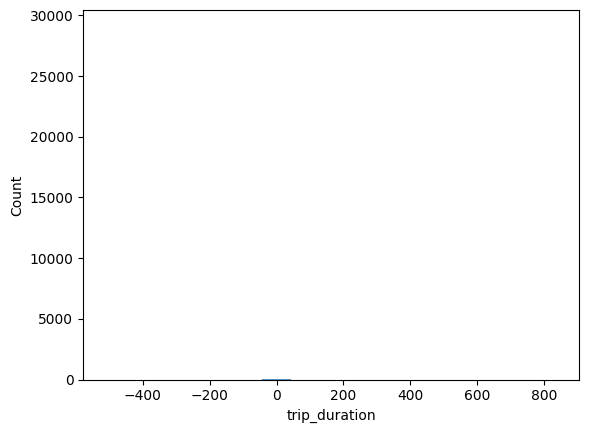

In [31]:
residuals = y_train - y_train_pred
sns.histplot(residuals, kde=False)
plt.show()

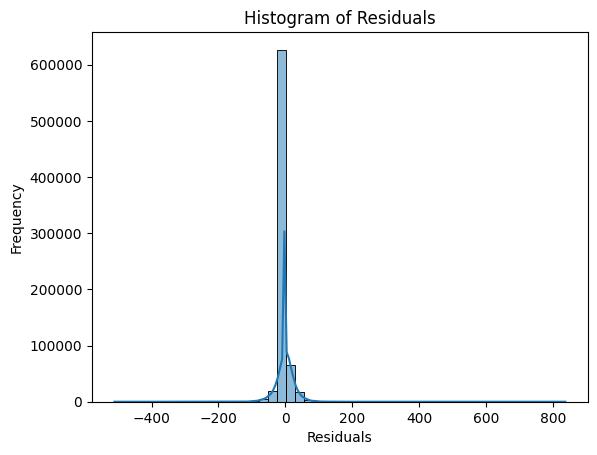

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the number of bins to make the histogram more readable
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()
